Аналитики коммерческой компании заметили, что из нее стали уходить клиенты.

В наличии есть данные о поведении клиентов и расторжении договоров с
компанией за прошлые периоды. Нужно спрогнозировать, уйдёт ли конкретный
клиент в ближайшее время или нет.

Сравните применимость трех моделей для задачи классификации: логистическая
регрессия, дерево, случайный лес.

Постройте модель с предельно большим значением F1-меры, метрика не должна
превышать до 0.65. Предварительно проверьте F1-меру на тестовой выборке
(согласуйте результат с преподавателем).

## Подготовка данных

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier


import warnings
warnings.filterwarnings("ignore")

In [58]:
df = pd.read_csv('./dataset.csv')

In [59]:
df.head()

,RowNumber,Id,CustomerId,Surname,Score,Geography,Gender,Age,Tenure,Balance,NumOfProducts,Has,IsActiveMember,EstimatedSalary,Exited
0,0,1,15634602,Hargrave,619,France,Female,42,1.0,83807.86,1,0,1,112542.58,0
1,1,2,15647311,Hill,608,Spain,Female,41,8.0,159660.80,3,1,0,113931.57,1
2,2,3,15619304,Onio,502,France,Female,42,1.0,0.00,2,0,0,93826.63,0
3,3,4,15701354,Boni,699,France,Female,39,2.0,125510.82,1,1,1,79084.10,0
4,4,5,15737888,Mitchell,850,Spain,Female,43,8.0,113755.78,2,1,0,149756.71,1


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        100 non-null    int64  
 1   Id               100 non-null    int64  
 2   CustomerId       100 non-null    int64  
 3   Surname          100 non-null    object 
 4   Score            100 non-null    int64  
 5   Geography        100 non-null    object 
 6   Gender           100 non-null    object 
 7   Age              100 non-null    int64  
 8   Tenure           94 non-null     float64
 9   Balance          100 non-null    float64
 10  NumOfProducts    100 non-null    int64  
 11  Has              100 non-null    int64  
 12  IsActiveMember   100 non-null    int64  
 13  EstimatedSalary  100 non-null    float64
 14  Exited           100 non-null    int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 11.8+ KB


In [61]:
df.describe()

,RowNumber,Id,CustomerId,Score,Age,Tenure,Balance,NumOfProducts,Has,IsActiveMember,EstimatedSalary,Exited
count,100.000000,100.000000,1.000000e+02,100.000000,100.000000,94.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.00000
mean,49.500000,50.500000,1.567823e+07,639.530000,38.030000,5.148936,72023.660100,1.510000,0.690000,0.500000,97366.42010,0.21000
std,29.011492,29.011492,7.003007e+04,112.652093,8.228375,2.739427,62534.675768,0.594503,0.464823,0.502519,55088.09138,0.40936
min,0.000000,1.000000,1.556654e+07,376.000000,24.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1914.41000,0.00000
25%,24.750000,25.750000,1.561006e+07,550.000000,32.750000,3.000000,0.000000,1.000000,0.000000,0.000000,53473.70000,0.00000
50%,49.500000,50.500000,1.568169e+07,634.000000,38.000000,5.000000,86846.455000,1.000000,1.000000,0.500000,97755.36500,0.00000
75%,74.250000,75.250000,1.573691e+07,726.000000,43.250000,7.000000,126071.762500,2.000000,1.000000,1.000000,139033.94000,0.00000
max,99.000000,100.000000,1.581466e+07,850.000000,61.000000,10.000000,183579.540000,4.000000,1.000000,1.000000,196526.55000,1.00000


- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевым признаком является столбец `Exited` — факт ухода клиента**

In [62]:
#Проверим на дубликаты
df.duplicated().sum()

0

Заметим, что в одном из столбцов есть пропуски, есть три варианта решения:

1) Удалить объекты с пропущенными значениями, так как количество их не очень велико(около 10%)

2) Заменить пропуски на минимальное значение

3) Заменить пропуски на медианное значение

In [63]:
df['Tenure'].describe()

count    94.000000
mean      5.148936
std       2.739427
min       0.000000
25%       3.000000
50%       5.000000
75%       7.000000
max      10.000000
Name: Tenure, dtype: float64

In [64]:
# Заполнение минимальными значениями
df['Tenure'] = df['Tenure'].fillna(0)

In [65]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

**Вывод**
- RowNumber — столбец дублирует информацию стандартного датафрейма и не несетя ценности для обучения модели. Поэтому столбец можно удалить
- CustomerId — является идентификатором пользователя (по данному столбцу значению необходимо проверить наличие дубликатов) и если отсутсвуют — стоблец также можно удалить.
- Surname — является идентифицирующей пользователя информацией, содержит 2932 уникальных значений, что сильно усложняет задачу, но не несет ценности для качества будущей модели — столбец можно удалить.
- Score — следует проверить распределение и сохранить данный столбец.
- Geography — всего 3 уникальных значения France', 'Spain', 'Germany' — выполнить преобразование OHE / ordinal encoding
- Gender — значение преобразовать — OHE / ordinal encoding.
- Age — Exited — тип данных верны.

## Исследование задачи

### Подготовка данных для машинного обучения

In [66]:
#Обозначим новый датафрейм "data_ml" — данные для машинного обучения
#Удалим столбцы-идентификаторы, не представляющие ценностия для алгоритма 
for_drop = ['RowNumber','CustomerId', 'Surname', 'Id']
df_ml = df.drop(for_drop, axis=1)
df_ml.head()

,Score,Geography,Gender,Age,Tenure,Balance,NumOfProducts,Has,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,1.0,83807.86,1,0,1,112542.58,0
1,608,Spain,Female,41,8.0,159660.80,3,1,0,113931.57,1
2,502,France,Female,42,1.0,0.00,2,0,0,93826.63,0
3,699,France,Female,39,2.0,125510.82,1,1,1,79084.10,0
4,850,Spain,Female,43,8.0,113755.78,2,1,0,149756.71,1


In [67]:
df_ml.shape

(100, 11)

In [68]:
# Данные подготовим методом OHE, что позволит нам использовать разные модели и не словить дамми ловушку
df_ml = pd.get_dummies(df_ml, drop_first=True)
df_ml.head()
print(df_ml)

    Score  Age  Tenure    Balance  NumOfProducts  Has  IsActiveMember  \
0     619   42     1.0   83807.86              1    0               1   
1     608   41     8.0  159660.80              3    1               0   
2     502   42     1.0       0.00              2    0               0   
3     699   39     2.0  125510.82              1    1               1   
4     850   43     8.0  113755.78              2    1               0   
..    ...  ...     ...        ...            ...  ...             ...   
95    771   35    10.0   57369.61              1    1               1   
96    516   36     7.0       0.00              1    0               1   
97    709   42     3.0   75075.31              2    1               0   
98    772   28     0.0  130142.79              1    1               0   
99    792   39    10.0  129845.26              1    1               1   

    EstimatedSalary  Exited  Geography_Germany  Geography_Spain  Gender_Male  
0         112542.58       0                 

In [69]:
df_ml.shape

(100, 12)

**Вывод**
В новом датафрейме кол-во столбцов увеличелост на 1 (стало 12)
Столбец Geography содержал 3 класса, Gender_Male 2 класса — в результате мы получили только 2 и 1 столбцов соответственно, что позволяет избежать дами-ловушки.

### Сформируем выборки

Обуч - 60, Валид - 20, тест - 20

In [70]:
#Разделим на признаки и целевой признак
features = df_ml.drop('Exited', axis=1)
target = df_ml['Exited']

In [71]:
#Валид 60%
features_train, features_validtest, target_train, target_validtest = train_test_split(features,
                                                    target,
                                                    train_size=0.6,
                                                    random_state=12345)

In [72]:
#Валид и тест соответственно поровну по 20% от общей
features_valid, features_test, target_valid, target_test = train_test_split(features_validtest,
                                                    target_validtest,
                                                    train_size=0.5,
                                                    random_state=12345)

**Вывод**
Были создана выборки:
- **Обучающая**
features_train
target_train

- **Валидационная**
features_valid
target_valid

- **Тестовая**
features_test
target_test

In [73]:
features_train.head()

,Score,Age,Tenure,Balance,NumOfProducts,Has,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
84,602,36,0.0,123841.49,2,1,0,96833.00,1,0,1
21,636,32,4.0,0.00,1,1,0,118913.53,0,1,0
79,677,35,6.0,74371.49,1,0,0,99595.67,0,0,0
62,702,33,2.0,126524.11,1,1,0,136869.31,0,1,1
18,587,45,6.0,0.00,2,1,1,54724.03,0,1,1


In [74]:
#Для масштабирования методом scaler зафиксируем численные признаки
numeric = ['Score', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [75]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [76]:
#Масштабируем числ признаки обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,Score,Age,Tenure,Balance,NumOfProducts,Has,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
84,-0.210710,-0.315004,-1.624178,0.818411,0.888523,1,0,-0.032328,1,0,1
21,0.089254,-0.822392,-0.232025,-1.197782,-0.888523,1,0,0.359477,0,1,0
79,0.450976,-0.441851,0.464051,0.013018,-0.888523,0,0,0.016694,0,0,0
62,0.671539,-0.695545,-0.928102,0.862085,-0.888523,1,0,0.678091,0,1,1
18,-0.343048,0.826620,0.464051,-1.197782,0.888523,1,1,-0.779525,0,1,1


In [77]:
#Масштабируем численные признаки валидационной выборки 
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,Score,Age,Tenure,Balance,NumOfProducts,Has,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
46,1.791995,-1.456627,1.508165,1.046375,-0.888523,1,1,0.336574,1,0,0
65,0.009852,-0.441851,-0.232025,0.852266,-0.888523,1,1,-1.388700,1,0,0
28,-0.457740,0.572926,-1.624178,-0.225886,0.888523,1,1,-0.801543,1,0,0
13,-0.678302,-1.710321,0.812089,-1.197782,0.888523,1,1,-0.580298,0,0,0
4,1.977267,0.572926,1.160127,0.654211,0.888523,1,0,0.906770,0,1,0


In [78]:
#Масштабируем численные признаки тестовой выборки 
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,Score,Age,Tenure,Balance,NumOfProducts,Has,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
71,1.827285,-1.583474,-0.232025,1.337729,-0.888523,1,0,1.293514,0,0,0
75,-0.140131,-0.695545,0.812089,0.485253,-0.888523,1,0,-0.252593,1,0,1
86,0.415686,-1.076086,1.160127,1.737706,0.888523,1,1,-1.716599,1,0,1
45,1.324403,-0.822392,1.508165,0.626370,-0.888523,1,1,0.373578,1,0,0
49,1.324403,-0.188156,-0.928102,-1.197782,-0.888523,1,1,0.047803,1,0,0


### Применение модели машинного обучения

В результате мы получили масштабированные признаки для трех выборок. Перейдем к обучению моделей.

In [79]:
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=1515)
    DTC_score = model_DTC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_RFC = RandomForestClassifier(max_depth=7, n_estimators=43, min_samples_leaf=3, random_state=1515)
    RFC_score = model_RFC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    LgR_score = model_LgR.fit(features_train, target_train).score(features_valid, target_valid)
    print("Точность:" "дерево решений", DTC_score, "случайный лес ", RFC_score, "логистческая регрессия", LgR_score)

In [80]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.7 случайный лес  0.85 логистческая регрессия 0.85


### Исследование баланса классов выборки

In [81]:
target_train.value_counts(normalize = 1)

0    0.766667
1    0.233333
Name: Exited, dtype: float64

<AxesSubplot:ylabel='Frequency'>

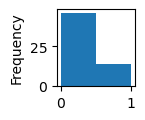

In [82]:
# Построим диаграмму баланса классов
target_train.plot(kind ='hist', bins=2, figsize=(1,1))

В выборке отрицательны ответов ≈80% , положитительных ≈ 20%.
С уверенностью можем сказать что **имеется дисбаланс.**

### Проверка адекватности

#### Проверим качество моделей до борьбы с дисбалансом

In [83]:
#Функцию для изучия полноты, точности и F1-меры
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

In [84]:
# Функция для отображения соотношения ответов моделей (сколько 0, сколько 1)
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=1515)
    model_DTC.fit(features_train, target_train)
    DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)
    
    
    
    model_RFC = RandomForestClassifier(random_state=1515, n_estimators = 100)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(features_train, target_train)
    LgR_share = pd.Series(model_LgR.predict(features_valid)).value_counts(normalize = 1)
    

    
    print("Доли ответов:" "Дерево решений", DTC_share, "Случайный лес ", RFC_share, "Логистческая регрессия", LgR_share , end='')

In [85]:
all_models_share(features_train, target_train, features_valid, target_valid)

Доли ответов:Дерево решений 0    0.75
1    0.25
dtype: float64 Случайный лес  0    0.95
1    0.05
dtype: float64 Логистческая регрессия 0    1.0
dtype: float64

Логистичесая регрессия показывала самую высокую точность, далее случайный лес и в конце дерево решений

С учетом дисбаланса результата модели с большой вероятностью будут выдавать ответ 0, построим матрицы ошибок для моделей

##### Случайный лес

In [86]:
model_RFC = RandomForestClassifier(random_state=1515, n_estimators = 100)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
confusion_matrix(target_valid, RFC_prediction)

array([[17,  0],
       [ 2,  1]])

In [87]:
rec_prec_f1(target_valid, RFC_prediction)

Полнота 0.3333333333333333
Точность 1.0
F1-мера 0.5


**Вывод** Случайный лес имеет примерно равную пропорцию позитивных и негативных предсказаний, выдает заметно больше качественных предсказаний, но также сильно склоняется к ложно позитивным предсказаниям (FP). Точность и качество также низкое.

##### Дерево решений

In [88]:
#Матрица ошибок для "дерево решений"
model_DTC = DecisionTreeClassifier(random_state=1515)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
confusion_matrix(target_valid, DTC_prediction)

array([[13,  4],
       [ 2,  1]])

**Вывод** Матрица показала, что дерево решений склонно выдавать позитивные предсказания, очень высокое количество ложных позитивных предсказания (FP).

In [89]:
rec_prec_f1(target_valid, DTC_prediction)

Полнота 0.3333333333333333
Точность 0.2
F1-мера 0.25


##### Логистическая регрессия

In [101]:
#Матрица ошибок для "логистической регрессии"
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
confusion_matrix(target_valid, LgR_prediction)

array([[17,  0],
       [ 3,  0]])

In [102]:
rec_prec_f1(target_valid, LgR_prediction)

Полнота 0.0
Точность 0.0
F1-мера 0.0


In [103]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

Score 0.85


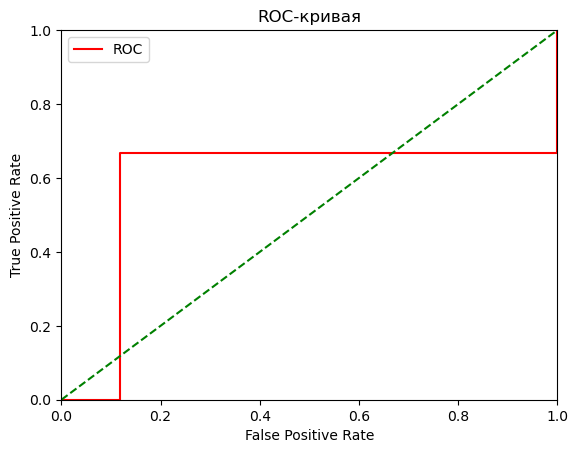

In [104]:
#Обучение логистической регресии сбалансировав классы
model_LgR = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR.fit(features_train, target_train)
LgR_probabilities_one_valid_class_weight = model_LgR.predict_proba(features_valid)[:, 1]
print("Score", model_LgR.score(features_valid, target_valid))

fper, tper, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid_class_weight) 
plot_roc_curve(fper, tper)

**Вывод** Отстутсвие улучшений - тоже результат. Высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке.

### Борьба с дисбалансом

Как мы выяснили ранее в нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%.
Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса. Либо же уменьшить кол-во отрицтаельных ответов.

- 1) Разделим обучающую выборку на отрицательные и положительные объекты;
- 2) Скопируем несколько раз положительные объекты;
- 3) С учётом полученных данных создадим новую обучающую выборку;
- 4) Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.
- 5) Обучим новые модели

In [105]:
#Функция для увеличения представленной класса в выборке 
def upsample(features, target, repeat, upsampled_сlass):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    else:
        features_upsampled = 0
        target_upsampled = 0  
        
        
       
    return features_upsampled, target_upsampled

In [106]:
#Функцию для уменьшения представленной класса в выборке 
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled
  

In [107]:
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, fraction=0.25)

In [108]:
#Протестируем функцию (верное значение)
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 0)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.929293
1    0.070707
Name: Exited, dtype: float64
(198,)


In [109]:
#Протестируем функцию (верное значение)
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 3)
features_train_upsampled

0

In [110]:
#Применим функцию upsample 
#увеличим количество положительных ответов в 4 раза
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

1    0.54902
0    0.45098
Name: Exited, dtype: float64
(102,)


In [111]:
#Применим функцию downsample
#Уменьшим кол-в пооложительных ответов в 4 раза
#Протестируем функцию (верное значение)
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.2)
print(target_downsampled_train.value_counts(normalize = 0))
print(target_downsampled_train.shape)

1    14
0     9
Name: Exited, dtype: int64
(23,)


<AxesSubplot:ylabel='Frequency'>

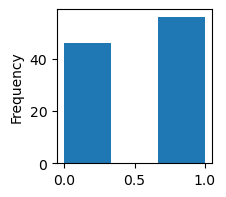

In [112]:
#Ну почти идеально и выигрышнее выглядит upsample с ним и будем работать
target_train_upsampled.plot(kind ='hist', bins=3, figsize=(2,2))

### Обучение моделей на сбалансированной выборке

In [113]:
#Точность моделей на выборке с дисбалансом
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.7 случайный лес  0.85 логистческая регрессия 0.85


In [114]:
#Точность моделей на сбалансированной выборке
all_models_accuracy(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Точность:дерево решений 0.85 случайный лес  0.8 логистческая регрессия 0.85


**Вывод** Точность сильно не изменилась. Проверим качество ответов.

In [115]:
#Решающее дерево
model_DTC_upsampled = DecisionTreeClassifier(random_state=1515)
model_DTC_upsampled.fit(features_train_upsampled, target_train_upsampled)
DTC_prediction_upsampled = model_DTC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, DTC_prediction_upsampled)

Полнота 0.3333333333333333
Точность 0.5
F1-мера 0.4


In [116]:
#Случайный лес
model_RFC_upsampled = RandomForestClassifier(max_depth=7, n_estimators=43, min_samples_leaf=3, random_state=1515)
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, RFC_prediction_upsampled)

Полнота 0.3333333333333333
Точность 0.3333333333333333
F1-мера 0.3333333333333333


In [117]:
#Логистическая регрессия
model_LgR_upsampled = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LgR_prediction_upsampled = model_LgR_upsampled.predict(features_valid)
rec_prec_f1(target_valid, LgR_prediction_upsampled)

Полнота 0.6666666666666666
Точность 0.5
F1-мера 0.5714285714285715


**Вывод**

Показаели всех моделей улучшились.

Лучшие результаты показывает алгоритм случайный лес (RandomForestClassifier). На валидационной выборке RandomForestClassifier уже показывает резульаты F1 меры = 0.61, что выше целевого целевого значения.

## Тестирование модели

In [118]:
#Обучиние финальной модели
model_RFC_final = RandomForestClassifier(
    bootstrap = True, class_weight = 'balanced', max_depth= 7,  n_estimators = 43, random_state=12345)
model_RFC_final.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=43,
                       random_state=12345)

In [119]:
model_RFC_final_prediction = model_RFC_final.predict(features_test)
rec_prec_f1(target_test, model_RFC_final_prediction)

Полнота 0.25
Точность 0.25
F1-мера 0.25


In [120]:
print('accuracy_score финальной модели:', accuracy_score(target_test, model_RFC_final_prediction))

accuracy_score финальной модели: 0.7


Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

## Выводы

- В первоначальные данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными), из-за чего обученная на этих данных модель не проходила проверку на адекватность. Все модели не первоначальных данных характеризовались высокой степенью ошибок и низким качеством взвешенной величины (F1) — модели показывали низкие результаты точности и полноты.

- Мы устранили дисбаланс классов в обучающей выборки методом upsampling — увеличили количество значений позитивного класса в 4 раза. Так мы достигли баланса классо в обучеющей выборки: 0 - 0.501043 1 - 0.498957

- Разобрали несколько вариантов борьбы с дисбалансом upsampling и downsampling

- На новых данных все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели случайного леса:
    - Полнота 0.722488038277512
    - Точность 0.5392857142857143
    - F1-мера 0.6175869120654396

- accuracy_score финальной модели: 0.7975